# Cotton Disease Prediction

## Libraries

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Constants
Providing the image size and the train-test paths.

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/Main dataset'
valid_path = '/content/drive/MyDrive/TEST'

## Model Initialisation

- Since the dataset set images are sized at (224, 224), we are selecting IMAGE_SIZE for this model.
- The dataset images are RGB, i.e. we have 3 channels, that's why we are selecting the input shape to be (224, 224, 3)
- We are using `imagenet` weights, since it has already 1000 categories, thus using pretrained weights.
- We are not including the top layer, that is the first layer, because we are providing our own top layer, i.e. IMAGE_SIZE.
- We are also removing the last layer, since that will be just our categories in which we want to classify the images (`#output_nodes = 4`).

In [ ]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top = False)

94765736/94765736 [==============================] - 1s 0us/step


Don't train the layers, we are going to use the existing weights from the ResNet50 model. We are doing this since we do not include the first and the last layer. We will be just training on the last layer.

In [ ]:
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
# Getting the number of output classes
folders = glob('/content/drive/MyDrive/Main dataset/*')
folders

['/content/drive/MyDrive/Main dataset/Aphids',
 '/content/drive/MyDrive/Main dataset/Target spot',
 '/content/drive/MyDrive/Main dataset/Army worm',
 '/content/drive/MyDrive/Main dataset/Bacterial Blight',
 '/content/drive/MyDrive/Main dataset/Powdery Mildew',
 '/content/drive/MyDrive/Main dataset/Healthy']

Flattening the model, so that we can add the number of nodes in the last layer, depending on the number of categories.

In [ ]:
x = Flatten()(resnet.output)

### Adding the Output Layer

- Creating a Dense layer, with `#nodes = len(folders) = #categories`
- Choosing Activation function as `softmax`, since it would provide probabilities across number of categories. If we had just 2 categories, then we could have used `sigmoid`.

Finally, we initialise the model, with the input layers, and the output layer.

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# Create model object
model = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Choosing the cost, optimization method and metric

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path, target_size = (224, 224), batch_size = 32, class_mode = 'categorical')

Found 3481 images belonging to 6 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(valid_path, target_size=(224, 224), batch_size = 32, class_mode = 'categorical')

Found 120 images belonging to 6 classes.


## Fit the model

In [ ]:
r = model.fit(
    training_set,
    validation_data = test_set,
    epochs = 30,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set)
)

Epoch 1/30
109/109 [==============================] - 885s 8s/step - loss: 3.2538 - accuracy: 0.2867 - val_loss: 1.3648 - val_accuracy: 0.4750
Epoch 2/30
109/109 [==============================] - 757s 7s/step - loss: 1.5669 - accuracy: 0.4332 - val_loss: 1.0524 - val_accuracy: 0.5917
Epoch 3/30
109/109 [==============================] - 775s 7s/step - loss: 1.4737 - accuracy: 0.4648 - val_loss: 0.9065 - val_accuracy: 0.6833
Epoch 4/30
109/109 [==============================] - 765s 7s/step - loss: 1.3845 - accuracy: 0.5191 - val_loss: 0.9127 - val_accuracy: 0.6250
Epoch 5/30
109/109 [==============================] - 759s 7s/step - loss: 1.3382 - accuracy: 0.5111 - val_loss: 0.6624 - val_accuracy: 0.7667
Epoch 6/30
109/109 [==============================] - 752s 7s/step - loss: 1.3722 - accuracy: 0.5197 - val_loss: 0.9675 - val_accuracy: 0.6333
Epoch 7/30
109/109 [==============================] - 777s 7s/step - loss: 1.3074 - accuracy: 0.5455 - val_loss: 1.0308 - val_accuracy: 0.6167

## Visualizations

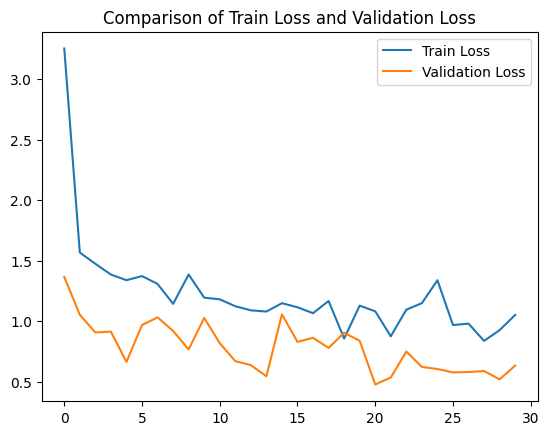

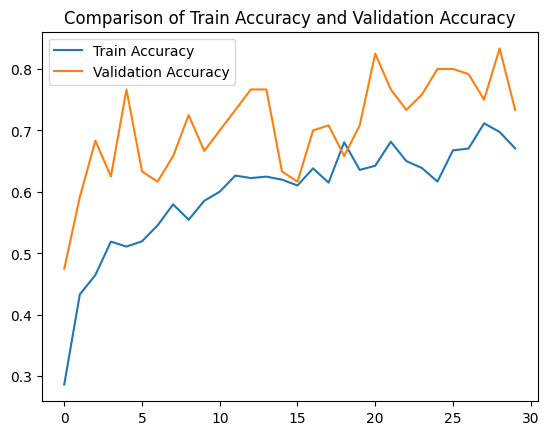

In [ ]:
# Plot the Loss
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.title('Comparison of Train Loss and Validation Loss')
plt.legend()
plt.savefig('loss_and_val_loss')
plt.show()

# Plot the Accuracy
plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.title('Comparison of Train Accuracy and Validation Accuracy')
plt.legend()
plt.savefig('accuracy_and_val_accuracy')
plt.show()

## Save the model

In [ ]:
model.save('cotton_disease_resent50.h5')

## Predictions

In [ ]:
y_pred = model.predict(test_set)
y_pred # Shows the probabilities of each category for each image from the test dataset

4/4 [==============================] - 34s 7s/step


array([[2.16138866e-02, 1.55298421e-05, 7.99460709e-03, 6.72894478e-01,
        2.71602362e-01, 2.58790962e-02],
       [6.69907458e-05, 9.71076369e-01, 2.62271242e-05, 2.86820717e-02,
        7.21611215e-08, 1.48084437e-04],
       [5.89754467e-10, 1.82792587e-06, 9.99985993e-01, 8.10428560e-08,
        3.49706539e-07, 1.17219943e-05],
       [3.96487832e-01, 7.91220069e-02, 3.61090988e-01, 3.71750593e-02,
        1.17434300e-01, 8.68974067e-03],
       [5.87678015e-01, 1.14841364e-01, 1.30749822e-01, 2.85153184e-02,
        6.00947125e-04, 1.37614474e-01],
       [4.10640387e-05, 1.00192692e-05, 4.42878554e-05, 9.99191821e-01,
        8.55632933e-08, 7.12638663e-04],
       [5.73572479e-02, 9.93372053e-02, 3.99523266e-02, 7.93877721e-01,
        1.23080303e-04, 9.35233664e-03],
       [2.44013555e-02, 2.79015512e-04, 3.82092372e-02, 1.60757974e-09,
        9.37103629e-01, 6.65584412e-06],
       [1.19512354e-03, 5.70428601e-05, 9.92426932e-01, 6.23241905e-03,
        4.13413339e-08, 

In [ ]:
# Selecting the category based on maximum probability
y_pred = np.argmax(y_pred, axis = 1)
y_pred

array([3, 1, 2, 0, 0, 3, 3, 4, 2, 5, 0, 3, 5, 0, 1, 3, 3, 4, 3, 4, 3, 0,
       0, 3, 3, 3, 1, 0, 0, 0, 5, 0, 2, 1, 0, 3, 5, 2, 0, 1, 2, 3, 1, 2,
       0, 4, 0, 1, 1, 5, 0, 1, 0, 3, 2, 0, 3, 3, 4, 5, 4, 0, 4, 0, 1, 2,
       3, 2, 2, 3, 5, 0, 0, 0, 1, 2, 2, 0, 3, 2, 1, 1, 3, 3, 0, 3, 1, 2,
       0, 0, 0, 1, 1, 4, 0, 3, 3, 0, 0, 0, 3, 3, 3, 2, 4, 0, 3, 5, 3, 3,
       0, 5, 3, 5, 4, 0, 1, 1, 3, 1])

# Getting the Requirements list

In [ ]:
!pip freeze > requirements.txt